# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.    
Задача — провести анализ и подготовить план действий по удержанию клиентов.  
А именно:  
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
проанализировать основные признаки, наиболее сильно влияющие на отток;  
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
1) выделить целевые группы клиентов;  
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.

# Загрузим данные

In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

In [3]:
# считываем файл с данными
try:
    df = pd.read_csv('gym_churn.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
# общая информация по таблице df
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


1. **Согласно документации данные клиента за предыдущий до проверки факта оттока месяц:**  

* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).  
2. **Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**  

* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* Churn' — факт оттока в текущем месяце.  

Всего 14 столбцов с данными, имеющимися в наличии в фитнес центре. Данные полные, пропущенных значений нет. 

In [5]:
# приведем колонки к нижнему регистру в змеином стиле
df.columns = df.columns.str.lower()

# Исследовательский анализ данных (EDA)

## Смотрим распределение данных

In [6]:
# проверим дубликаты
print(f'Всего дубликатов {df.duplicated().sum()} в таблице')

Всего дубликатов 0 в таблице


In [7]:
# смотрим распределение набора данных
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


По распределению данных можем сделать следующие выводы:  
- Предположительно мужчин и женщин одинково посетителей в фитнес центре
- Почти 85% посетителей проживает в районе нахождения фитнеса
- 48% посетителей работают в компаниях партнерах фитнес центра
- 30% пришедших по промокоду при оплате первого абонента
- 90% посетителей оставили свой контактный телефон
- в среднем немногим больще 4 месяцев длительность текущего абонента, а также стандартное отклонение. Можем видеть, что большинство обанентов имеют месячную подписку.
- 60% участвовало в групповых занятиях
- средний возраст посетителей 29 лет, вообще посетители центра представляют собой людей от 18 до 41 года.
- выручка от других услуг фитнес центра 146 условных единиц со стандартным отклонением 96
- в среднем пользователь 4 месяца является посетителем фитнес центра, стандартное отклонение тоже порядка 4 месяцев
- в среднем почти 2 посещения в неделю у пользователей, а 2/3 пользователей имеют от 1 до 3 посещений в неделю, такое же примерно поведение пользователей за предыдущий месяц
- в текущем месяце отток посетителей имеет порядка 27%

## Средние значения по группам оттока и оставшихся посетителей

In [8]:
# посмотрим на средние значения признаков по группам оттока и тех, кто остался
mean_churn_df = df.groupby('churn').mean()
mean_churn_df.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Что мы можем выделить в среднем:
- отток посетителей больше в проживающих не в районе фитнес-центра
- сотрудники партнерских компаний уходят реже
- пришедшие по промо посетители уходят в 2 раза реже в среднем
- уходят реже посетители длительных абонентов
- отток больше среди тех, кто не посещает групповые занятия
- отток посетителей меньше среди пользующими иными услугами
- уходят больше абоненты с коротким сроком пользования услугами и небольшим окончанием действия абонента
- отток среди посетителей, посещающих фитнес-центр в среднем 1 раз в неделю

## Гистограммы для групп оттока и оставшихся посетителей

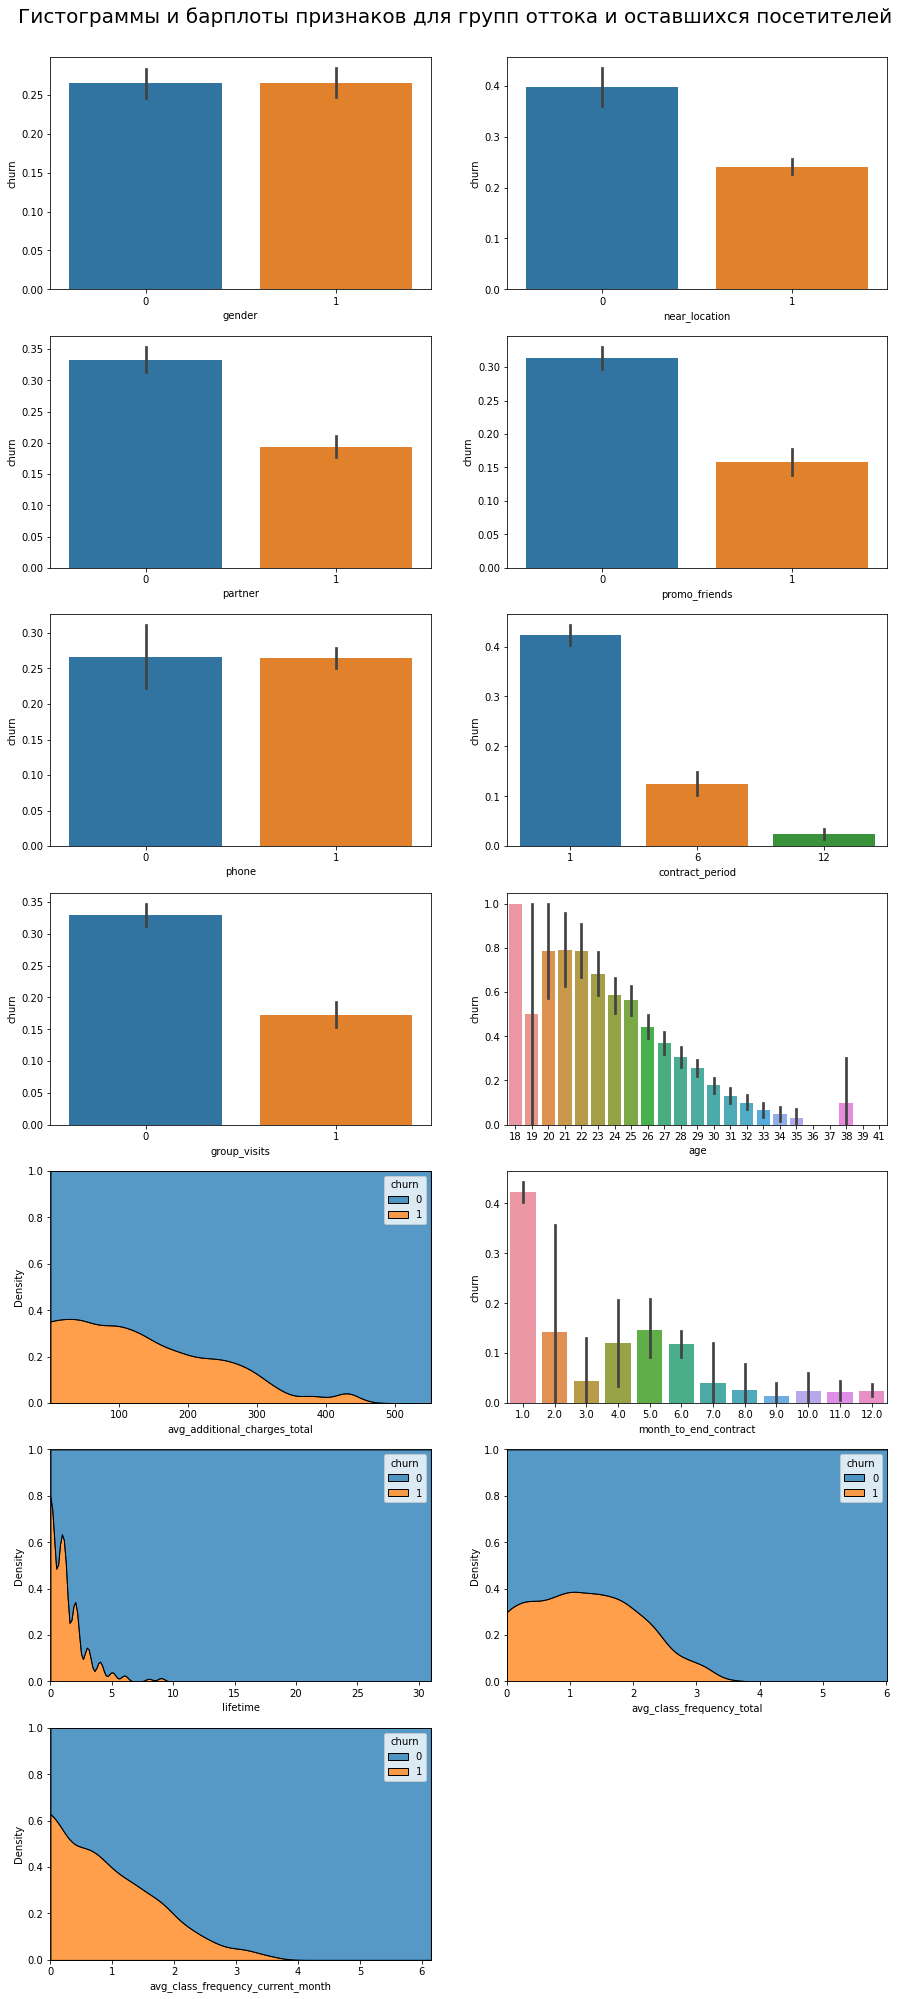

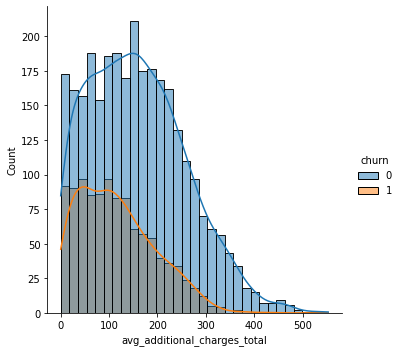

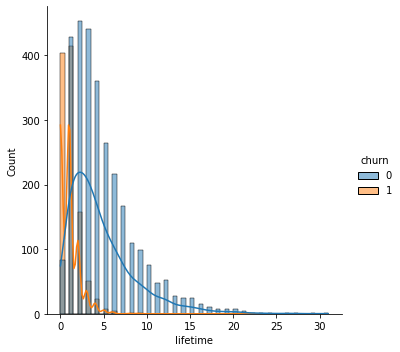

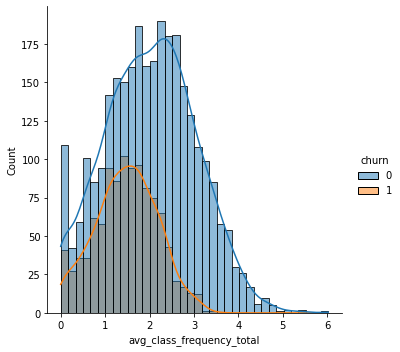

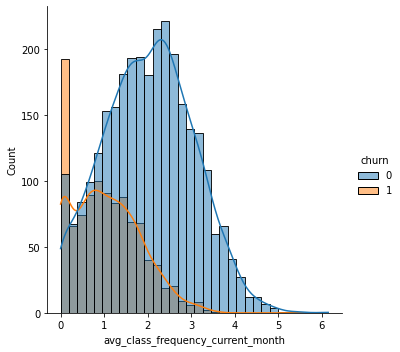

In [9]:
# построим аналог гистрограммы и барплоты всех признаков по группам оттока и оставшихся пользователей столбец *churn*
count_column = round(len(df.columns) / 2)
# выделяем столбцы с дискретными данными для выделяния постороения отдельных графиков
column_discrete = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 
                   'group_visits', 'contract_period', 'month_to_end_contract', 'age', 'churn']

ma
for i, column in enumerate(df.drop('churn', axis=1).columns):
    ax = fig.add_subplot(count_column, 2, i+1)
    if column in column_discrete:
        sns.barplot(x=column, y='churn', data=df)
    else:
        sns.kdeplot(data=df, x=column, hue='churn', multiple="fill", cut=0)
        
for column in df.drop(column_discrete, axis=1).columns:        
        sns.displot(data=df, x=column, hue='churn', kde=True)
      
fig.suptitle('Гистограммы и барплоты признаков для групп оттока и оставшихся посетителей', fontsize=20, y=0.9)
plt.show()

По гистрограммам интересное можно увидеть  
- уходят чаще те, у кого абонемент на 1 месяц, на годовом абонементе реже намного отток
- до 26 лет доля ушедших половина и чем моложе, тем больше отток;  
- те, кто тратит на прочие услуги больше 350 резко уменьшается количество уходящих;  
- наибольшее число уходит посетителей тех, у кого абонент остается на 1 месяц;  
- чем больше по времени клиент фитнес-центра, тем меньше шанс твоего ухода;  
- количество посещений меньше 2 в неделю даёт большой шанс оказаться в кругу ушедших.

## Построим матрицу корреляции

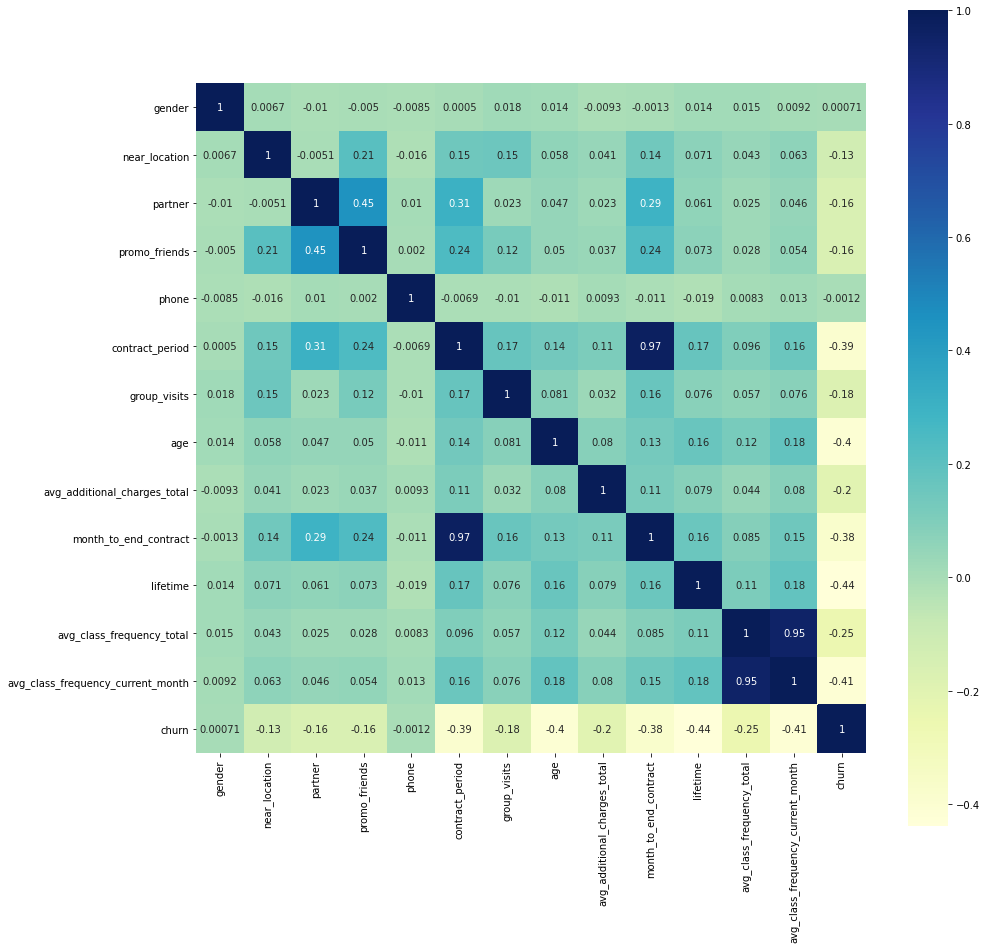

In [9]:
# корреляционная таблица
corr_m = df.corr()

# стоим хитмэп по корреляционной таблице посмотреть зависимости признаков с оттоком пользователей
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True, cmap="YlGnBu")
plt.show()

Касаемо оттока наибольшие отрицательные корреляции с длительностью `текущего абонента`, `возрастом`, `сроком окончания абонемента`, `средней частотой посещений` и `временем с момента первого обращения`.    
Также мы можем обнаружить на корреляционной таблице, что признаки `avg_class_frequency_total` и `avg_class_frequency_сurrent_month`, а также `contract_period` и `month_to_end_contract` мультиколлинеарны между собой.  
Так как мы планируем обучать нашу модель двумя способами:  
- логистической регрессией
- случайным лесом  
то для модели, обученной методом логистической регрессии, модель критична в плане мультиколлинеарности, поэтому удалим один из каждых двух слолбцов для проведения обучения. Обучение модели случайным лесом не подвержена мультиколлинеарности, для неё нет необходимости от них избавляться.

# Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

## Разобьём данные на обучающую и валидационную выборку функцией train_test_split()

In [10]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['churn', 'avg_class_frequency_current_month', 'month_to_end_contract'], axis=1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку 80 к 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## Обучим модель на train-выборке логистической регрессией

In [11]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [12]:
# задаем алгоритм для нашей модели
model_log_regres = LogisticRegression(class_weight={0:.1, 1:.3}, solver='liblinear', random_state=0)

# обучаем модель
model_log_regres.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_reg = model_log_regres.predict(X_test_st)

## Обучим модель на train-выборке случайным лесом

In [13]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(class_weight={0:.1, 1:.3}, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)

## Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.

In [14]:
# выведем все метрики
print(f'Метрики для модели логистической регрессии:\n{classification_report(y_test, predictions_reg)}')
print(f'Метрики для модели случайного леса:\n{classification_report(y_test, rf_predictions)}')

Метрики для модели логистической регрессии:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       588
           1       0.69      0.95      0.80       212

    accuracy                           0.88       800
   macro avg       0.84      0.90      0.85       800
weighted avg       0.90      0.88      0.88       800

Метрики для модели случайного леса:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       588
           1       0.84      0.78      0.81       212

    accuracy                           0.90       800
   macro avg       0.88      0.86      0.87       800
weighted avg       0.90      0.90      0.90       800



мы видим, что полнота целевого класса (клиентов, которые уйдут) в первой модели больше, хоть точность при этом и меньше: она более склонна к ошибке, но зато большая часть посетителей, которые действительно склонны к тому, чтобы покинуть наш зал, будет распознана, в сравнении со второй моделью. Но тут уже важно знать экономику процессов: сколько бизнесу стоит потерять и удержать клиента.

# Кластеризация клиентов

## Стандарттизируем данные

In [15]:
# стандартизация данных перед работой с алгоритмами кластеризации
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop('churn', axis=1))

## Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить

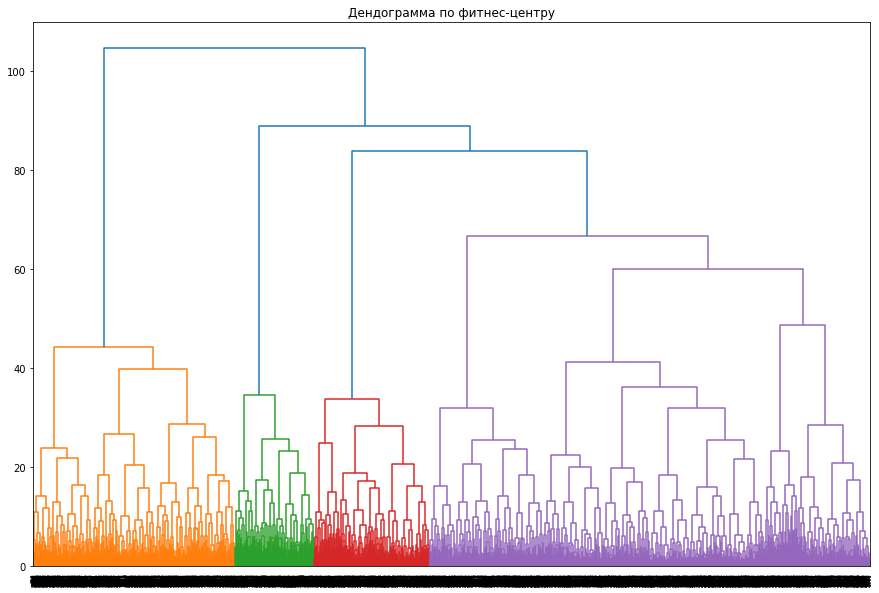

In [16]:
# передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage()
# чтобы диаграмма вышла показательной передадим параметру method значение 'ward'
linked = linkage(X_sc, method = 'ward')

# В переменной linked сохранена таблица «связок» между объектами. Визуализируем её как дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма по фитнес-центру')
plt.show() 

По дендограмме оптимально было бы выделение 4 кластеров, по цветам на графике.

## Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

Договоримся за число кластеров принять n=5, чтобы результаты можно было сравнивать с результатами остальных. Так, если смотреть по дендограмме, я бы выделил 4 кластера.

In [17]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

In [18]:
# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


## Посмотрим на средние значения признаков для кластеров.

In [19]:
# выводим статистику по средним значениям наших признаков по кластеру
mean_cluster = df.groupby('cluster_km').mean()
display(mean_cluster)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Что мы можем сразу заметить:
- кластер 2 исключает проживание клиентов в районе нахождения фитнес-центра
- сотрудников компаний явно больше в нулевом кластере, чем в остальных
- промокодом от друга воспользовались больше в нулевом кластере и совсем немного во втором
- в первом кластере у клиентов отсутствует контактный телефон
- в нулевом кластере клиенты в среднем почти на 11 месяцев имеют абонемент, в первом почти на 5, в остальных кластерах порядка 2-3 месяцев
- сумарная выручка больше в нулевом и 4 кластерах
- время с первого обращения в центр больше в 4 и 0 кластерах, близка к 5 месяцев
- средняя частота посещений выше в 4 кластере, а ниже в 3 кластере среди всех
- самый большой уход наблюдается среди 3 группы и затем 2 группы, а минимальный уход в 0 и 4 кластерах

## Построим распределения признаков для кластеров

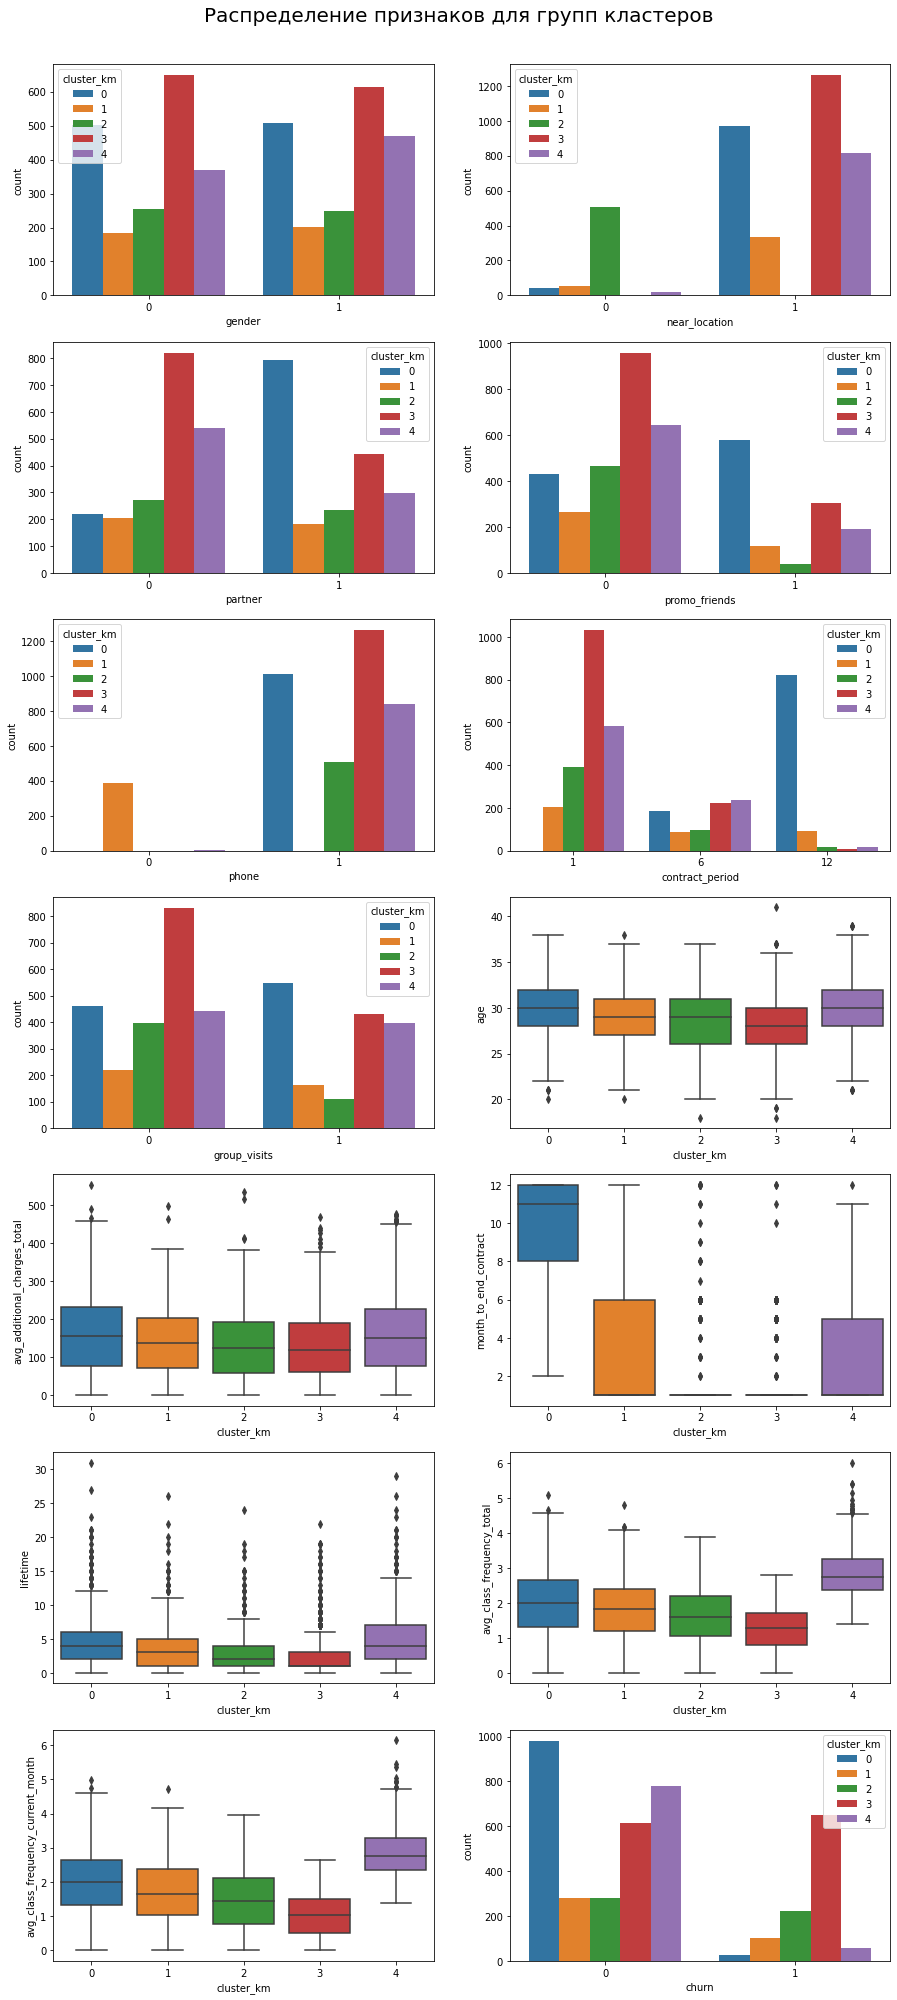

In [20]:
# построим распределение всех признаков по группам кластеров
count_column = round(len(df.columns) / 2)
# выделяем столбцы с дискретными данными для выделяния постороения гистрограмм, остальные столбцы построятся boxplot
column_countplot = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 
                   'group_visits', 'contract_period', 'churn']

fig = plt.figure(figsize=(15, count_column*5))
for i, column in enumerate(df.drop('cluster_km', axis=1).columns):
    ax = fig.add_subplot(count_column, 2, i+1)
    if column in column_countplot:
        sns.countplot(data=df, x=column, hue='cluster_km')
    else:
        sns.boxplot(data=df, y=column, x='cluster_km')
        
fig.suptitle('Распределение признаков для групп кластеров', fontsize=20, y=0.9)
plt.show()

Распределения повторяют выводы, сделанные выше по средним значениям для кластеров. 

## Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

Доля оттока посетителей фитнес-центра по кластерам 
cluster_km
0    0.03
1    0.27
2    0.44
3    0.51
4    0.07
Name: churn, dtype: float64


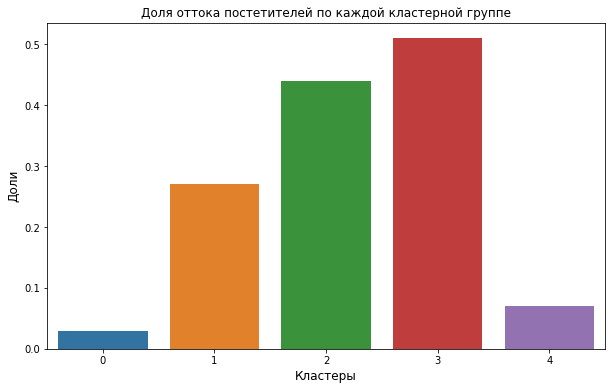

In [21]:
# выводим статистику по средним значениям наших признаков по кластеру
cluster_churn = df.groupby('cluster_km')['churn'].mean().round(2)
print(f'Доля оттока посетителей фитнес-центра по кластерам \n{cluster_churn}')

plt.figure(figsize = (10,6))
sns.barplot(x=cluster_churn.index, y=cluster_churn.values)
plt.title('Доля оттока постетителей по каждой кластерной группе')
plt.ylabel('Доли', fontsize = 12)
plt.xlabel('Кластеры', fontsize = 12)
plt.show()

В среднем по всем посетителям доля оттока была примерно 27% из данных, которые мы смотрели по таблице.  
Если брать по кластерам, то доля оттока в 0 и 4 кластере 3% и 7% - посетители из этих кластеров с очень небольшой вероятностью склонны уходить.  
Кластер 1 по оттоку повторяем общую картину, а вот кластеры 2 и 3 имеют почти половину и половину ушедших.

# Выводы и базовые рекомендации по работе с клиентами

Если смотреть на группы повышенного оттока и небольшого оттока посетителей, то выделяются зависимости:  
- групповые занятия уменьшают вероятность оттока посетителя
- траты посетителя на другие услуги фитнес-центра прямо пропорциональны вероятности оставаться клиентом
- средняя посещаемость прямо пропорциональна оставаться клиентом фитнес-центра  

С учётом выводов, могу рекомендовать провести бонусное со скидкой или вообще одно бесплатное групповое занятие для посетителей, которые месяц посещают фитнес-центр и которые не посещали ранее такие занятия. Также можно со скидкой предложить такое занятие тем, у кого посещаемость упала в последние недели и составляет 1-2 раза в неделю.  
Предложу включить в абонемент включенную скидку 2% на дополнительные услуги фитнес-центра, а через время проверить, насколько это имело окупаемость. Или предложить акцию, кто посещает от 3 раз в неделю занятия без пропусков, тот имеет право на бонусную услугу, предоставляемую фитнес центром с дисконтом. 